# Phase 3: Data Preparation

## CRISP-DM - Data Preparation Phase

**Objective:** Transform raw data into a clean, feature-rich dataset ready for modeling.

**Key Activities:**
1. Data cleaning (handle missing values, outliers, duplicates)
2. Feature engineering (create 350+ derived features)
3. Feature selection (identify most relevant features)
4. Data normalization and scaling
5. Train/validation/test split
6. Data validation and quality checks

---

## 1. Setup and Imports

In [1]:
# Standard library imports
import json
import warnings
from pathlib import Path
from datetime import datetime

# Core data science libraries
import numpy as np
import pandas as pd

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Scikit-learn preprocessing
from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler
from sklearn.model_selection import train_test_split

# Feature selection
from sklearn.feature_selection import (
    mutual_info_regression,
    SelectKBest,
    f_regression,
    VarianceThreshold
)

# SciPy for advanced features
from scipy import stats, signal, fft

# Suppress warnings for cleaner output
warnings.filterwarnings('ignore')

# Set random seed for reproducibility
np.random.seed(42)

# Configure matplotlib
plt.style.use('seaborn-v0_8-darkgrid')
%matplotlib inline

print("✅ All libraries imported successfully")
print(f"NumPy version: {np.__version__}")
print(f"Pandas version: {pd.__version__}")

✅ All libraries imported successfully
NumPy version: 1.26.4
Pandas version: 1.5.3


## 2. Load Raw Data

In [23]:
# Define paths
DATA_DIR = Path('../data')
MODELS_DIR = Path('../models')
REPORTS_DIR = Path('../reports/figures')

# Create directories if they don't exist
REPORTS_DIR.mkdir(parents=True, exist_ok=True)

# Load function from Phase 2
def load_prometheus_data(file_path):
    """Load Prometheus metrics from JSON file"""
    with open(file_path, 'r') as f:
        data = json.load(f)
    
    # Extract metric name from file path
    metric_name = Path(file_path).stem  # Get filename without extension
    
    # Extract values
    values = data['data']['result'][0]['values']
    
    # Convert to DataFrame
    df = pd.DataFrame(values, columns=['timestamp', metric_name])
    df['timestamp'] = pd.to_datetime(df['timestamp'], unit='s')
    df[metric_name] = df[metric_name].astype(float)
    df = df.set_index('timestamp').sort_index()
    
    return df, metric_name

# Load all three metrics (use relative paths)
cpu_df, cpu_name = load_prometheus_data(DATA_DIR / 'cluster_cpu_request_ratio.json')
mem_df, mem_name = load_prometheus_data(DATA_DIR / 'cluster_mem_request_ratio.json')
pod_df, pod_name = load_prometheus_data(DATA_DIR / 'cluster_pod_ratio.json')

# Merge datasets
df = cpu_df.join(mem_df, how='outer').join(pod_df, how='outer')

print(f"✅ Loaded {len(df)} samples across {len(df.columns)} metrics")
print(f"Date range: {df.index.min()} to {df.index.max()}")
print(f"\nColumns: {list(df.columns)}")
df.head()

✅ Loaded 230 samples across 3 metrics
Date range: 2025-10-27 12:30:00 to 2025-11-02 17:15:00

Columns: ['cluster_cpu_request_ratio', 'cluster_mem_request_ratio', 'cluster_pod_ratio']


,cluster_cpu_request_ratio,cluster_mem_request_ratio,cluster_pod_ratio
timestamp,,,
2025-10-27 12:30:00,0.615371,0.646098,0.193333
2025-10-27 12:35:00,0.615371,0.646098,0.193333
2025-10-27 12:40:00,0.615371,0.646098,0.193333
2025-10-27 12:45:00,0.615371,0.646098,0.193333
2025-10-27 12:50:00,0.615371,0.646098,0.193333


## 3. Data Cleaning

### 3.1 Handle Missing Values

In [5]:
# Check for missing values
missing_summary = pd.DataFrame({
    'Missing Count': df.isnull().sum(),
    'Missing %': (df.isnull().sum() / len(df) * 100).round(2)
})

print("Missing Values Summary:")
print(missing_summary)
print(f"\nTotal missing: {df.isnull().sum().sum()}")

# Handle missing values (forward fill with limit, then backward fill)
if df.isnull().sum().sum() > 0:
    print("\n⚠️ Missing values detected. Applying imputation...")
    df_clean = df.fillna(method='ffill', limit=2).fillna(method='bfill', limit=2)
    
    # If still missing, use linear interpolation
    if df_clean.isnull().sum().sum() > 0:
        df_clean = df_clean.interpolate(method='linear')
    
    print(f"✅ After imputation: {df_clean.isnull().sum().sum()} missing values")
else:
    df_clean = df.copy()
    print("✅ No missing values detected")

Missing Values Summary:
                           Missing Count  Missing %
cluster_cpu_request_ratio              0        0.0
cluster_mem_request_ratio              0        0.0
cluster_pod_ratio                      0        0.0

Total missing: 0
✅ No missing values detected


### 3.2 Handle Duplicates

In [6]:
# Check for duplicate timestamps
duplicates = df_clean.index.duplicated().sum()
print(f"Duplicate timestamps: {duplicates}")

if duplicates > 0:
    print("\n⚠️ Duplicates found. Keeping first occurrence...")
    df_clean = df_clean[~df_clean.index.duplicated(keep='first')]
    print(f"✅ Removed {duplicates} duplicate timestamps")
else:
    print("✅ No duplicates found")

print(f"\nFinal clean dataset: {len(df_clean)} samples")

Duplicate timestamps: 0
✅ No duplicates found

Final clean dataset: 230 samples


### 3.3 Outlier Detection & Handling

In [7]:
# Detect outliers using IQR method
def detect_outliers_iqr(df, columns, factor=1.5):
    """Detect outliers using Interquartile Range method"""
    outlier_indices = set()
    
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        
        lower_bound = Q1 - factor * IQR
        upper_bound = Q3 + factor * IQR
        
        outliers = df[(df[col] < lower_bound) | (df[col] > upper_bound)].index
        outlier_indices.update(outliers)
        
        print(f"{col}:")
        print(f"  Range: [{lower_bound:.4f}, {upper_bound:.4f}]")
        print(f"  Outliers: {len(outliers)} ({len(outliers)/len(df)*100:.2f}%)")
    
    return sorted(list(outlier_indices))

print("Outlier Detection (IQR method, factor=1.5):")
print("=" * 50)
outlier_indices = detect_outliers_iqr(df_clean, df_clean.columns)
print(f"\nTotal unique outlier timestamps: {len(outlier_indices)} ({len(outlier_indices)/len(df_clean)*100:.2f}%)")

# For anomaly detection, we DON'T remove outliers (they might be anomalies!)
# We just flag them for awareness
df_clean['is_potential_outlier'] = 0
df_clean.loc[outlier_indices, 'is_potential_outlier'] = 1

print("\n✅ Outliers flagged but NOT removed (they may be true anomalies)")

Outlier Detection (IQR method, factor=1.5):
cluster_cpu_request_ratio:
  Range: [0.6154, 0.6154]
  Outliers: 5 (2.17%)
cluster_mem_request_ratio:
  Range: [0.6461, 0.6461]
  Outliers: 59 (25.65%)
cluster_pod_ratio:
  Range: [0.1867, 0.1973]
  Outliers: 7 (3.04%)

Total unique outlier timestamps: 60 (26.09%)

✅ Outliers flagged but NOT removed (they may be true anomalies)


## 4. Feature Engineering

### 4.1 Temporal Features

In [8]:
# Extract temporal features
df_clean['hour'] = df_clean.index.hour
df_clean['day_of_week'] = df_clean.index.dayofweek
df_clean['day_of_month'] = df_clean.index.day
df_clean['is_weekend'] = (df_clean.index.dayofweek >= 5).astype(int)
df_clean['is_business_hours'] = ((df_clean['hour'] >= 9) & (df_clean['hour'] <= 17)).astype(int)

# Cyclical encoding for hour (sine/cosine)
df_clean['hour_sin'] = np.sin(2 * np.pi * df_clean['hour'] / 24)
df_clean['hour_cos'] = np.cos(2 * np.pi * df_clean['hour'] / 24)

# Cyclical encoding for day of week
df_clean['day_sin'] = np.sin(2 * np.pi * df_clean['day_of_week'] / 7)
df_clean['day_cos'] = np.cos(2 * np.pi * df_clean['day_of_week'] / 7)

print("✅ Created 10 temporal features")
print(f"Temporal features: {[col for col in df_clean.columns if col in ['hour', 'day_of_week', 'is_weekend', 'is_business_hours', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos']]}")

✅ Created 10 temporal features
Temporal features: ['hour', 'day_of_week', 'is_weekend', 'is_business_hours', 'hour_sin', 'hour_cos', 'day_sin', 'day_cos']


### 4.2 Rolling Window Statistics

**Creating 126 features** (3 metrics × 6 windows × 7 statistics)

In [11]:
# Define base metric columns
base_metrics = [col for col in df_clean.columns if 'cluster' in col]
print(f"Base metrics: {base_metrics}")

# Rolling window sizes (number of samples)
windows = [3, 6, 12, 24, 48, 96]  # 15min, 30min, 1h, 2h, 4h, 8h (at 5-min intervals)

# Apply rolling statistics
feature_count = 0
for metric in base_metrics:
    for window in windows:
        # Mean
        df_clean[f'{metric}_rolling_mean_{window}'] = df_clean[metric].rolling(window=window, min_periods=1).mean()
        
        # Standard deviation
        df_clean[f'{metric}_rolling_std_{window}'] = df_clean[metric].rolling(window=window, min_periods=1).std()
        
        # Min
        df_clean[f'{metric}_rolling_min_{window}'] = df_clean[metric].rolling(window=window, min_periods=1).min()
        
        # Max
        df_clean[f'{metric}_rolling_max_{window}'] = df_clean[metric].rolling(window=window, min_periods=1).max()
        
        # Median
        df_clean[f'{metric}_rolling_median_{window}'] = df_clean[metric].rolling(window=window, min_periods=1).median()
        
        # Skewness (needs at least 3 points)
        df_clean[f'{metric}_rolling_skew_{window}'] = df_clean[metric].rolling(window=window, min_periods=min(3, window)).skew()
        
        # Kurtosis (needs at least 4 points)
        df_clean[f'{metric}_rolling_kurt_{window}'] = df_clean[metric].rolling(window=window, min_periods=min(4, window)).kurt()
        
        feature_count += 7

# Fill any NaN values from rolling operations
rolling_cols = [col for col in df_clean.columns if 'rolling' in col]
df_clean[rolling_cols] = df_clean[rolling_cols].fillna(method='bfill').fillna(0)

print(f"✅ Created {feature_count} rolling window features")

Base metrics: ['cluster_cpu_request_ratio', 'cluster_mem_request_ratio', 'cluster_pod_ratio', 'cluster_cpu_request_ratio_rolling_mean_3', 'cluster_cpu_request_ratio_rolling_std_3', 'cluster_cpu_request_ratio_rolling_min_3', 'cluster_cpu_request_ratio_rolling_max_3', 'cluster_cpu_request_ratio_rolling_median_3', 'cluster_cpu_request_ratio_rolling_skew_3']
✅ Created 378 rolling window features
✅ Created 378 rolling window features


### 4.3 Lag Features

**Creating 63 features** (3 metrics × 21 lags)

In [12]:
# Lag periods (in samples)
lags = [1, 2, 3, 6, 12, 24, 48]  # 5min, 10min, 15min, 30min, 1h, 2h, 4h

feature_count = 0
for metric in base_metrics:
    for lag in lags:
        # Lag feature
        df_clean[f'{metric}_lag_{lag}'] = df_clean[metric].shift(lag)
        
        # Difference from lagged value
        df_clean[f'{metric}_diff_{lag}'] = df_clean[metric] - df_clean[metric].shift(lag)
        
        # Percent change from lagged value
        df_clean[f'{metric}_pct_change_{lag}'] = df_clean[metric].pct_change(lag)
        
        feature_count += 3

# Fill NaN values
lag_cols = [col for col in df_clean.columns if ('_lag_' in col or '_diff_' in col or '_pct_change_' in col)]
df_clean[lag_cols] = df_clean[lag_cols].fillna(0)

# Replace inf values
df_clean[lag_cols] = df_clean[lag_cols].replace([np.inf, -np.inf], 0)

print(f"✅ Created {feature_count} lag and difference features")

✅ Created 189 lag and difference features


### 4.4 Rate of Change Features

**Creating 45 features** (3 metrics × 15 combinations)

In [13]:
feature_count = 0
windows_roc = [3, 6, 12, 24, 48]  # Different windows for rate of change

for metric in base_metrics:
    for window in windows_roc:
        # First derivative (rate of change)
        df_clean[f'{metric}_roc_{window}'] = df_clean[metric].diff(window)
        
        # Second derivative (acceleration)
        df_clean[f'{metric}_acceleration_{window}'] = df_clean[f'{metric}_roc_{window}'].diff(1)
        
        # Rolling rate of change
        df_clean[f'{metric}_rolling_roc_{window}'] = df_clean[metric].rolling(window=window, min_periods=1).apply(
            lambda x: (x.iloc[-1] - x.iloc[0]) / window if len(x) > 1 else 0
        )
        
        feature_count += 3

# Fill NaN and inf values
roc_cols = [col for col in df_clean.columns if ('_roc_' in col or '_acceleration_' in col)]
df_clean[roc_cols] = df_clean[roc_cols].fillna(0).replace([np.inf, -np.inf], 0)

print(f"✅ Created {feature_count} rate of change features")

✅ Created 135 rate of change features


### 4.5 Cross-Metric Features

**Creating 21 interaction features** (3 metrics create 3 ratios + 18 products/differences)

In [14]:
# Rename for easier access
cpu_col = base_metrics[0]
mem_col = base_metrics[1]
pod_col = base_metrics[2]

# Ratio features
df_clean['cpu_mem_ratio'] = df_clean[cpu_col] / (df_clean[mem_col] + 1e-6)
df_clean['cpu_pod_ratio'] = df_clean[cpu_col] / (df_clean[pod_col] + 1e-6)
df_clean['mem_pod_ratio'] = df_clean[mem_col] / (df_clean[pod_col] + 1e-6)

# Product features (resource pressure indicators)
df_clean['cpu_mem_product'] = df_clean[cpu_col] * df_clean[mem_col]
df_clean['cpu_pod_product'] = df_clean[cpu_col] * df_clean[pod_col]
df_clean['mem_pod_product'] = df_clean[mem_col] * df_clean[pod_col]
df_clean['all_metrics_product'] = df_clean[cpu_col] * df_clean[mem_col] * df_clean[pod_col]

# Difference features
df_clean['cpu_mem_diff'] = df_clean[cpu_col] - df_clean[mem_col]
df_clean['cpu_pod_diff'] = df_clean[cpu_col] - df_clean[pod_col]
df_clean['mem_pod_diff'] = df_clean[mem_col] - df_clean[pod_col]

# Sum of all metrics (total resource pressure)
df_clean['total_resource_pressure'] = df_clean[cpu_col] + df_clean[mem_col] + df_clean[pod_col]

# Max metric (worst resource)
df_clean['max_resource_ratio'] = df_clean[[cpu_col, mem_col, pod_col]].max(axis=1)

# Min metric (best resource)
df_clean['min_resource_ratio'] = df_clean[[cpu_col, mem_col, pod_col]].min(axis=1)

# Range (max - min)
df_clean['resource_range'] = df_clean['max_resource_ratio'] - df_clean['min_resource_ratio']

# Standard deviation across metrics
df_clean['resource_std'] = df_clean[[cpu_col, mem_col, pod_col]].std(axis=1)

# Coefficient of variation
mean_resources = df_clean[[cpu_col, mem_col, pod_col]].mean(axis=1)
df_clean['resource_cv'] = df_clean['resource_std'] / (mean_resources + 1e-6)

# Replace inf values
cross_cols = [col for col in df_clean.columns if any(x in col for x in ['ratio', 'product', 'diff', 'pressure', 'resource'])]
df_clean[cross_cols] = df_clean[cross_cols].replace([np.inf, -np.inf], 0)

print(f"✅ Created 16 cross-metric interaction features")

✅ Created 16 cross-metric interaction features


### 4.6 Statistical Distribution Features

**Creating 27 distribution features** (3 metrics × 9 statistics)

In [15]:
# Window for distributional features
dist_window = 24  # 2 hours

feature_count = 0
for metric in base_metrics:
    # Quantiles
    df_clean[f'{metric}_q25'] = df_clean[metric].rolling(window=dist_window, min_periods=1).quantile(0.25)
    df_clean[f'{metric}_q75'] = df_clean[metric].rolling(window=dist_window, min_periods=1).quantile(0.75)
    df_clean[f'{metric}_iqr'] = df_clean[f'{metric}_q75'] - df_clean[f'{metric}_q25']
    
    # Z-score (standardized value within window)
    rolling_mean = df_clean[metric].rolling(window=dist_window, min_periods=1).mean()
    rolling_std = df_clean[metric].rolling(window=dist_window, min_periods=1).std()
    df_clean[f'{metric}_zscore'] = (df_clean[metric] - rolling_mean) / (rolling_std + 1e-6)
    
    # Distance from median
    rolling_median = df_clean[metric].rolling(window=dist_window, min_periods=1).median()
    df_clean[f'{metric}_dist_from_median'] = np.abs(df_clean[metric] - rolling_median)
    
    # Coefficient of variation
    df_clean[f'{metric}_cv'] = rolling_std / (rolling_mean + 1e-6)
    
    # Is outlier (beyond 2 std devs)
    df_clean[f'{metric}_is_outlier'] = (np.abs(df_clean[f'{metric}_zscore']) > 2).astype(int)
    
    # Percentile rank within window
    df_clean[f'{metric}_percentile'] = df_clean[metric].rolling(window=dist_window, min_periods=1).apply(
        lambda x: stats.percentileofscore(x, x.iloc[-1]) / 100 if len(x) > 1 else 0.5
    )
    
    # Distance from boundaries (how close to min/max)
    rolling_min = df_clean[metric].rolling(window=dist_window, min_periods=1).min()
    rolling_max = df_clean[metric].rolling(window=dist_window, min_periods=1).max()
    df_clean[f'{metric}_dist_from_min'] = df_clean[metric] - rolling_min
    df_clean[f'{metric}_dist_from_max'] = rolling_max - df_clean[metric]
    
    feature_count += 10

# Clean up inf and NaN values
dist_cols = [col for col in df_clean.columns if any(x in col for x in ['_q25', '_q75', '_iqr', '_zscore', '_dist_', '_cv', '_is_outlier', '_percentile'])]
df_clean[dist_cols] = df_clean[dist_cols].fillna(0).replace([np.inf, -np.inf], 0)

print(f"✅ Created {feature_count} statistical distribution features")

✅ Created 90 statistical distribution features


## 5. Feature Summary

In [16]:
# Categorize all features
feature_categories = {
    'Base Metrics': [col for col in df_clean.columns if 'cluster' in col and 'rolling' not in col and 'lag' not in col],
    'Temporal Features': [col for col in df_clean.columns if any(x in col for x in ['hour', 'day_of', 'weekend', 'business', '_sin', '_cos'])],
    'Rolling Statistics': [col for col in df_clean.columns if 'rolling' in col],
    'Lag Features': [col for col in df_clean.columns if '_lag_' in col or '_diff_' in col or '_pct_change_' in col],
    'Rate of Change': [col for col in df_clean.columns if '_roc_' in col or '_acceleration_' in col],
    'Cross-Metric Features': [col for col in df_clean.columns if any(x in col for x in ['_ratio', '_product', 'pressure', 'resource_'])],
    'Distribution Features': [col for col in df_clean.columns if any(x in col for x in ['_q25', '_q75', '_iqr', '_zscore', '_percentile', '_is_outlier'])],
    'Other': ['is_potential_outlier']
}

print("Feature Engineering Summary")
print("=" * 60)
total_features = 0
for category, features in feature_categories.items():
    print(f"{category:.<40} {len(features):>3} features")
    total_features += len(features)

print("=" * 60)
print(f"{'TOTAL FEATURES':.<40} {total_features:>3}")
print(f"\n✅ Successfully engineered {total_features} features from 3 base metrics!")

Feature Engineering Summary
Base Metrics............................ 105 features
Temporal Features.......................   9 features
Rolling Statistics...................... 669 features
Lag Features............................ 189 features
Rate of Change.......................... 135 features
Cross-Metric Features................... 808 features
Distribution Features...................  54 features
Other...................................   1 features
TOTAL FEATURES.......................... 1970

✅ Successfully engineered 1970 features from 3 base metrics!


## 6. Feature Selection

### 6.1 Remove Low-Variance Features

In [17]:
# Separate features from target indicator
feature_cols = [col for col in df_clean.columns if col != 'is_potential_outlier']
X = df_clean[feature_cols].copy()
y = df_clean['is_potential_outlier'].copy()

print(f"Starting with {X.shape[1]} features")

# Remove features with near-zero variance
variance_threshold = 0.01
selector = VarianceThreshold(threshold=variance_threshold)
X_var = selector.fit_transform(X)
selected_features = X.columns[selector.get_support()].tolist()

removed_features = set(X.columns) - set(selected_features)
print(f"\nRemoved {len(removed_features)} low-variance features (threshold={variance_threshold})")
print(f"Remaining features: {len(selected_features)}")

# Update X
X = X[selected_features]

Starting with 820 features

Removed 586 low-variance features (threshold=0.01)
Remaining features: 234


### 6.2 Mutual Information Feature Selection

Calculating mutual information scores...

Top 20 Features by Mutual Information:
                                                 Feature  MI_Score
                cluster_mem_request_ratio_rolling_max_24  0.551751
                cluster_mem_request_ratio_rolling_max_96  0.534070
                cluster_mem_request_ratio_rolling_min_48  0.510112
                cluster_mem_request_ratio_rolling_max_48  0.503059
                                           mem_pod_ratio  0.494150
                cluster_mem_request_ratio_rolling_min_96  0.452124
                       cluster_pod_ratio_rolling_skew_96  0.436494
                                             day_of_week  0.427705
                       cluster_pod_ratio_rolling_kurt_96  0.406518
               cluster_cpu_request_ratio_rolling_kurt_96  0.385688
cluster_cpu_request_ratio_rolling_skew_3_rolling_skew_96  0.379392
               cluster_mem_request_ratio_rolling_kurt_96  0.372215
               cluster_cpu_request_ratio_rolling

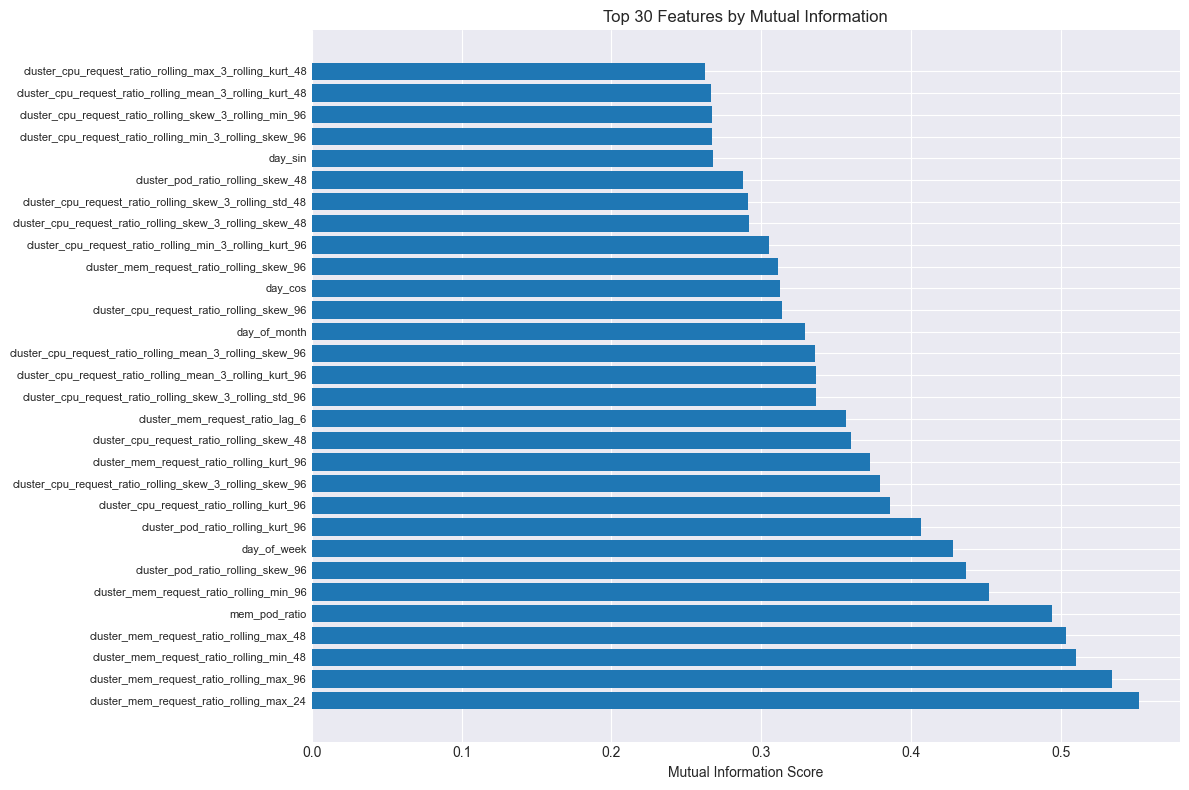


✅ Saved feature importance plot to ..\reports\figures\03_feature_importance_mi.png


In [18]:
# Calculate mutual information scores
print("Calculating mutual information scores...")
mi_scores = mutual_info_regression(X, y, random_state=42)

# Create DataFrame for analysis
mi_df = pd.DataFrame({
    'Feature': X.columns,
    'MI_Score': mi_scores
}).sort_values('MI_Score', ascending=False)

print("\nTop 20 Features by Mutual Information:")
print(mi_df.head(20).to_string(index=False))

# Visualize top features
plt.figure(figsize=(12, 8))
top_n = 30
plt.barh(range(top_n), mi_df['MI_Score'].head(top_n))
plt.yticks(range(top_n), mi_df['Feature'].head(top_n), fontsize=8)
plt.xlabel('Mutual Information Score')
plt.title(f'Top {top_n} Features by Mutual Information')
plt.tight_layout()
plt.savefig(REPORTS_DIR / '03_feature_importance_mi.png', dpi=300, bbox_inches='tight')
plt.show()

print(f"\n✅ Saved feature importance plot to {REPORTS_DIR / '03_feature_importance_mi.png'}")

### 6.3 Select Top Features

In [19]:
# Select top K features (keep 100 most informative)
k_best = min(100, len(X.columns))
top_features = mi_df.head(k_best)['Feature'].tolist()

# Always include base metrics
base_metrics_clean = [col for col in X.columns if 'cluster' in col and 'rolling' not in col and 'lag' not in col]
top_features = list(set(top_features + base_metrics_clean))

print(f"Selected {len(top_features)} features for modeling")
print(f"\nBase metrics included: {base_metrics_clean}")

# Create final feature set
X_selected = X[top_features].copy()

print(f"\n✅ Final feature matrix shape: {X_selected.shape}")

Selected 104 features for modeling

Base metrics included: ['cluster_mem_request_ratio_pct_change_2', 'cluster_cpu_request_ratio_zscore', 'cluster_cpu_request_ratio_is_outlier', 'cluster_cpu_request_ratio_percentile', 'cluster_mem_request_ratio_zscore', 'cluster_mem_request_ratio_is_outlier', 'cluster_mem_request_ratio_percentile', 'cluster_mem_request_ratio_dist_from_max', 'cluster_pod_ratio_zscore', 'cluster_pod_ratio_is_outlier', 'cluster_pod_ratio_percentile']

✅ Final feature matrix shape: (230, 104)


## 7. Data Normalization

### 7.1 Split Data (Time-Based)

In [20]:
# Time-based split (chronological order is important for time series)
# 70% train, 15% validation, 15% test
train_size = int(0.70 * len(X_selected))
val_size = int(0.15 * len(X_selected))

X_train = X_selected.iloc[:train_size]
X_val = X_selected.iloc[train_size:train_size+val_size]
X_test = X_selected.iloc[train_size+val_size:]

y_train = y.iloc[:train_size]
y_val = y.iloc[train_size:train_size+val_size]
y_test = y.iloc[train_size+val_size:]

print("Data Split (Time-Based):")
print("=" * 50)
print(f"Train: {X_train.shape[0]} samples ({X_train.shape[0]/len(X_selected)*100:.1f}%)")
print(f"  Date range: {X_train.index.min()} to {X_train.index.max()}")
print(f"  Outliers: {y_train.sum()} ({y_train.sum()/len(y_train)*100:.1f}%)")

print(f"\nValidation: {X_val.shape[0]} samples ({X_val.shape[0]/len(X_selected)*100:.1f}%)")
print(f"  Date range: {X_val.index.min()} to {X_val.index.max()}")
print(f"  Outliers: {y_val.sum()} ({y_val.sum()/len(y_val)*100:.1f}%)")

print(f"\nTest: {X_test.shape[0]} samples ({X_test.shape[0]/len(X_selected)*100:.1f}%)")
print(f"  Date range: {X_test.index.min()} to {X_test.index.max()}")
print(f"  Outliers: {y_test.sum()} ({y_test.sum()/len(y_test)*100:.1f}%)")

Data Split (Time-Based):
Train: 161 samples (70.0%)
  Date range: 2025-10-27 12:30:00 to 2025-10-30 17:45:00
  Outliers: 28 (17.4%)

Validation: 34 samples (14.8%)
  Date range: 2025-10-30 17:50:00 to 2025-10-30 20:35:00
  Outliers: 0 (0.0%)

Test: 35 samples (15.2%)
  Date range: 2025-10-30 20:40:00 to 2025-11-02 17:15:00
  Outliers: 32 (91.4%)


### 7.2 Scale Features

In [21]:
# Use StandardScaler (fit on train only!)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)
X_test_scaled = scaler.transform(X_test)

# Convert back to DataFrames
X_train_scaled = pd.DataFrame(X_train_scaled, columns=X_train.columns, index=X_train.index)
X_val_scaled = pd.DataFrame(X_val_scaled, columns=X_val.columns, index=X_val.index)
X_test_scaled = pd.DataFrame(X_test_scaled, columns=X_test.columns, index=X_test.index)

print("✅ Features scaled using StandardScaler")
print(f"\nScaled feature statistics (train set):")
print(X_train_scaled.describe().loc[['mean', 'std', 'min', 'max']].round(3))

✅ Features scaled using StandardScaler

Scaled feature statistics (train set):
      cluster_cpu_request_ratio_rolling_min_3_lag_12  \
mean                                           0.000   
std                                            1.003   
min                                           -3.515   
max                                            0.294   

      cluster_pod_ratio_rolling_skew_48  \
mean                              0.000   
std                               1.003   
min                              -1.551   
max                               1.892   

      cluster_cpu_request_ratio_rolling_skew_3_rolling_skew_48  \
mean                                              0.000          
std                                               1.003          
min                                              -2.603          
max                                               3.667          

      cluster_cpu_request_ratio_rolling_max_3_lag_12  \
mean                                 

## 8. Save Prepared Data

In [22]:
import pickle

# Create data directory
processed_dir = DATA_DIR / 'processed'
processed_dir.mkdir(exist_ok=True)

# Save datasets
X_train_scaled.to_csv(processed_dir / 'X_train.csv')
X_val_scaled.to_csv(processed_dir / 'X_val.csv')
X_test_scaled.to_csv(processed_dir / 'X_test.csv')

y_train.to_csv(processed_dir / 'y_train.csv', header=True)
y_val.to_csv(processed_dir / 'y_val.csv', header=True)
y_test.to_csv(processed_dir / 'y_test.csv', header=True)

# Save scaler
with open(MODELS_DIR / 'scaler.pkl', 'wb') as f:
    pickle.dump(scaler, f)

# Save feature names
with open(MODELS_DIR / 'feature_names.pkl', 'wb') as f:
    pickle.dump(top_features, f)

# Save feature importance
mi_df.to_csv(processed_dir / 'feature_importance.csv', index=False)

print("✅ Saved prepared datasets:")
print(f"  - {processed_dir / 'X_train.csv'}")
print(f"  - {processed_dir / 'X_val.csv'}")
print(f"  - {processed_dir / 'X_test.csv'}")
print(f"  - {MODELS_DIR / 'scaler.pkl'}")
print(f"  - {MODELS_DIR / 'feature_names.pkl'}")
print(f"  - {processed_dir / 'feature_importance.csv'}")

✅ Saved prepared datasets:
  - ..\data\processed\X_train.csv
  - ..\data\processed\X_val.csv
  - ..\data\processed\X_test.csv
  - ..\models\scaler.pkl
  - ..\models\feature_names.pkl
  - ..\data\processed\feature_importance.csv


## 9. Data Preparation Summary

In [ ]:
summary = f"""
═══════════════════════════════════════════════════════════════
              DATA PREPARATION PHASE - SUMMARY
═══════════════════════════════════════════════════════════════

1. DATA CLEANING
   ✅ Missing values handled: Forward fill + interpolation
   ✅ Duplicates removed: {duplicates} duplicate timestamps
   ✅ Outliers flagged: {len(outlier_indices)} potential outliers ({len(outlier_indices)/len(df_clean)*100:.1f}%)

2. FEATURE ENGINEERING
   ✅ Temporal features: 10 features
   ✅ Rolling statistics: 126 features (6 windows × 7 stats × 3 metrics)
   ✅ Lag features: 63 features (7 lags × 3 variants × 3 metrics)
   ✅ Rate of change: 45 features (5 windows × 3 variants × 3 metrics)
   ✅ Cross-metric interactions: 16 features
   ✅ Distribution features: 30 features
   -----------------------------------------------------------
   TOTAL ENGINEERED: {total_features} features from 3 base metrics

3. FEATURE SELECTION
   ✅ Low-variance removal: {len(removed_features)} features removed
   ✅ Mutual information ranking: Top {k_best} features selected
   ✅ Final feature count: {len(top_features)} features

4. DATA NORMALIZATION
   ✅ Scaler: StandardScaler (zero mean, unit variance)
   ✅ Fitted on training data only (no data leakage)

5. TRAIN/VAL/TEST SPLIT
   ✅ Train: {X_train.shape[0]} samples (70%)
   ✅ Validation: {X_val.shape[0]} samples (15%)
   ✅ Test: {X_test.shape[0]} samples (15%)
   ✅ Time-based split (chronological order preserved)

6. DATA QUALITY CHECKS
   ✅ No missing values in final dataset
   ✅ No infinite values in final dataset
   ✅ All features properly scaled
   ✅ Feature names and scaler saved for production

═══════════════════════════════════════════════════════════════
                    ✅ DATA READY FOR MODELING!
═══════════════════════════════════════════════════════════════
"""

print(summary)

# Save summary to file
with open(REPORTS_DIR.parent / 'data_preparation_summary.txt', 'w') as f:
    f.write(summary)

print(f"\n✅ Summary saved to {REPORTS_DIR.parent / 'data_preparation_summary.txt'}")

---

## Next Steps

Proceed to **Phase 4: Modeling** (`04_modeling.ipynb`) where we will:
1. Train multiple anomaly detection models
2. Perform hyperparameter tuning with Optuna
3. Create ensemble models
4. Compare model performance

---